In [1]:
setwd("/mnt/expressions/mp/nea-over-time/notebooks")

In [2]:
library(here)
library(tidyverse)
library(future)
library(forcats)
library(furrr)
library(cowplot)

library(admixr)

plan(multiprocess, workers = 30)

source(here("code/utils.R"))

here() starts at /mnt/expressions/mp/nea-over-time
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [3]:
snps_capture <- eigenstrat(here("data/eigenstrat/bigyri_ho/all"))

In [4]:
snps_wgs <- eigenstrat(here("data/eigenstrat/whole_genome/whole_genome"))

In [5]:
samples <- load_samples() %>%
    filter(!pop %in% c("Oceania")) %>%
    mutate(name = case_when(name == "new_UstIshim" ~ "UstIshim",
                            name == "new_Loschbour" ~ "Loschbour",
                            TRUE ~ name))

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [27]:
near_east <- c("BedouinB", "Yemenite_Jew", "Palestinian", "Iraqi_Jew", "Jordanian", "Druze", "Iranian", "Samaritan")

In [318]:
cat(near_east)

BedouinB Yemenite_Jew Palestinian Iraqi_Jew Jordanian Druze Iranian Samaritan

In [316]:
samples %>% group_by(pop) %>% tally

pop,n
<chr>,<int>
Africa,19
America,10
CentralAsiaSiberia,15
EastAsia,22
EMH,50
SouthAsia,19
WestEurasia,35


# Direct f4-ratio on whole-genome data

In [6]:
nea_wgs %<-% f4ratio(
    X = filter(samples, pop %in% c("WestEurasia", "EastAsia"))$name,
    A = "new_Altai", B = "new_Vindija", C = "Yoruba", O = "Chimp",
    data = snps_wgs
)

In [177]:
nea_wgs <- inner_join(nea_wgs, samples, by = c("X" = "name")) %>%
    mutate(sites = "whole-genome",
           pop = ifelse(X %in% near_east, "NearEast", pop),
           pop = factor(pop, levels = c("EastAsia", "WestEurasia", "NearEast")))

# Direct f4-ratio on capture SNP data

In [7]:
nea_capture <- future_map_dfr(
    filter(samples, pop == "Africa")$name, 
    ~ f4ratio(
        X = filter(samples, pop %in% c("WestEurasia", "EastAsia"))$name,
        A = "new_Altai", B = "new_Vindija", C = .x, O = "Chimp",
        data = snps_capture
    )
)

In [48]:
nea_capture <- inner_join(nea_capture, samples, by = c("X" = "name")) %>%
    mutate(sites = "2M sites capture",
           pop = ifelse(X %in% near_east, "NearEast", pop),
           pop = factor(pop, levels = c("EastAsia", "WestEurasia", "NearEast")))

# Combine both data frames

In [133]:
nea <- bind_rows(nea_capture, nea_wgs)

In [233]:
saveRDS(nea, "/mnt/expressions/mp/archaic-ychr/data/rds/david_nb.rds")

# Figures

In [362]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

p_nea_capture <- nea %>% filter(sites == "2M sites capture") %>%
mutate(pop = ifelse(pop == "NearEast", "WestEurasia", pop)) %>% 
ggplot(aes(fct_reorder(C, alpha), alpha)) +
    geom_point(aes(group = pop, color = pop), size = 0.5, position = position_dodge(width = 0.75)) +
    geom_boxplot(outlier.shape = NA, aes(group = interaction(C, pop)), size = 0.25, alpha = 0.5) +
    theme_minimal() +
    theme(
        strip.text = element_text(face = "bold"),  
        legend.position = "none",
        axis.text.x = element_text(hjust = 1, angle = 45)
    ) +
    labs(x = "", y = "direct-f4 ratio estimate") +
    facet_wrap(~ sites, scales = "free_x") +
    coord_cartesian(y = c(0, 0.03)) +
    ggtitle("Figure #1 - Neanderthal ancestry in East Asians and West Eurasians",
            "Each dot is a single individual; each pair of boxplots shows Neanderthal estimates using different Africans")

p_nea_wgs <- nea %>% filter(sites == "whole-genome") %>% 
mutate(pop = ifelse(pop == "NearEast", "WestEurasia", pop)) %>% 
ggplot(aes(fct_reorder(C, alpha), alpha)) +
    geom_point(aes(group = pop, color = pop), size = 0.5, position = position_dodge(width = 0.75)) +
    geom_boxplot(outlier.shape = NA, aes(group = interaction(C, pop)), size = 0.25, alpha = 0.5) +
    theme_minimal() +
    theme(
        strip.text = element_text(face = "bold"),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_text(hjust = 1, angle = 45),
        plot.margin = unit(c(0.75, 0, 1.525, 0), "cm")
    ) +
    facet_wrap(~ sites, scales = "free_x") +
    coord_cartesian(y = c(0, 0.03)) +
    ggtitle("")

fig1 <- plot_grid(p_nea_capture, p_nea_wgs, rel_widths = c(3.5, 1))

In [363]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

p_nea_capture <- nea %>% filter(sites == "2M sites capture") %>% 
mutate(pop = factor(pop, levels = c("EastAsia", "WestEurasia", "NearEast"))) %>%
ggplot(aes(fct_reorder(C, alpha), alpha)) +
    geom_point(aes(group = pop, color = pop), size = 0.5, position = position_dodge(width = 0.75)) +
    geom_boxplot(outlier.shape = NA, aes(group = interaction(C, pop)), size = 0.25, alpha = 0.5) +
    theme_minimal() +
    theme(
        strip.text = element_text(face = "bold"),  
        legend.position = "none",
        axis.text.x = element_text(hjust = 1, angle = 45)
    ) +
    labs(x = "", y = "direct-f4 ratio estimate") +
    facet_wrap(~ sites, scales = "free_x") +
    coord_cartesian(y = c(0, 0.03)) +
    ggtitle("Figure #2 - Neanderthal ancestry in East Asians and West Eurasians (Near Easterners plotted separately)",
            "Each dot is a single individual; each trio of boxplots shows Neanderthal estimates using different Africans")

p_nea_wgs <- nea %>% filter(sites == "whole-genome") %>% 
mutate(pop = factor(pop, levels = c("EastAsia", "WestEurasia", "NearEast"))) %>%
ggplot(aes(fct_reorder(C, alpha), alpha)) +
    geom_point(aes(group = pop, color = pop), size = 0.5, position = position_dodge(width = 0.75)) +
    geom_boxplot(outlier.shape = NA, aes(group = interaction(C, pop)), size = 0.25, alpha = 0.5) +
    theme_minimal() +
    theme(
        strip.text = element_text(face = "bold"),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_text(hjust = 1, angle = 45),
        plot.margin = unit(c(0.73, 0, 1.525, 0), "cm")
    ) +
    facet_wrap(~ sites, scales = "free_x") +
    coord_cartesian(y = c(0, 0.03)) +
    ggtitle("")

fig2 <- plot_grid(p_nea_capture, p_nea_wgs, rel_widths = c(3.5, 1))

In [364]:
p_ratio_capture <- nea %>%
filter(sites == "2M sites capture") %>%
mutate(pop = ifelse(pop == "NearEast", "WestEurasia", pop)) %>% 
group_by(C, pop) %>% summarise(mean = mean(alpha)) %>%
spread(pop, mean) %>%
mutate(ratio_eur_vs_eas = EastAsia / WestEurasia) %>%
arrange(ratio_eur_vs_eas) %>%
ggplot(aes(fct_reorder(C, (EastAsia + WestEurasia) / 3), ratio_eur_vs_eas)) + geom_point() +
    coord_cartesian(y = c(1, 1.4)) +
    labs(x = "", y = "East Asian vs West Eurasian Neand. ancestry") +
    geom_hline(yintercept = 1, linetype = 4) +
    theme_minimal() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("Figure #3 - Ratio of average East Asian vs average West Eurasian Neanderthal ancestry", "2M sites capture")

p_ratio_wgs <- nea %>%
filter(sites == "whole-genome") %>%
mutate(pop = ifelse(pop == "NearEast", "WestEurasia", pop)) %>% 
group_by(C, pop) %>% summarise(mean = mean(alpha)) %>%
spread(pop, mean) %>%
mutate(ratio_eur_vs_eas = EastAsia / WestEurasia) %>%
arrange(ratio_eur_vs_eas) %>%
ggplot(aes(fct_reorder(C, (EastAsia + WestEurasia) / 3), ratio_eur_vs_eas)) + geom_point() +
    coord_cartesian(y = c(1, 1.4)) +
    labs(x = "", y = "East Asian vs West Eurasian Neand. ancestry") +
    geom_hline(yintercept = 1, linetype = 4) +
    theme_minimal() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    theme(
        strip.text = element_text(face = "bold"),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_text(hjust = 1, angle = 45),
        plot.margin = unit(c(0.2, 0, 1.5, 0), "cm")
    ) +
    ggtitle("", "whole-genome")

fig3 <- plot_grid(p_ratio_capture, p_ratio_wgs, rel_widths = c(8, 1))

In [365]:
p_ratio_capture <- nea %>%
filter(sites == "2M sites capture") %>%
group_by(C, pop) %>% summarise(mean = mean(alpha)) %>%
spread(pop, mean) %>%
mutate(ratio_eur_vs_eas = EastAsia / WestEurasia) %>%
arrange(ratio_eur_vs_eas) %>%
ggplot(aes(fct_reorder(C, (EastAsia + NearEast + WestEurasia) / 3), ratio_eur_vs_eas)) + geom_point() +
    coord_cartesian(y = c(1, 1.4)) +
    labs(x = "", y = "East Asian vs West Eurasian Neand. ancestry") +
    geom_hline(yintercept = 1, linetype = 4) +
    theme_minimal() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("Figure #4 - Ratio of average East Asian vs average West Eurasian Neanderthal ancestry, excluding Near Easterners",
            "2M sites capture")

p_ratio_wgs <- nea %>%
filter(sites == "whole-genome") %>%
group_by(C, pop) %>% summarise(mean = mean(alpha)) %>%
spread(pop, mean) %>%
mutate(ratio_eur_vs_eas = EastAsia / WestEurasia) %>%
arrange(ratio_eur_vs_eas) %>%
ggplot(aes(fct_reorder(C, (EastAsia + NearEast + WestEurasia) / 3), ratio_eur_vs_eas)) + geom_point() +
    coord_cartesian(y = c(1, 1.4)) +
    labs(x = "", y = "East Asian vs West Eurasian Neand. ancestry") +
    geom_hline(yintercept = 1, linetype = 4) +
    theme_minimal() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    theme(
        strip.text = element_text(face = "bold"),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_text(hjust = 1, angle = 45),
        plot.margin = unit(c(0.2, 0, 1.5, 0), "cm")
    ) +
    ggtitle("", "whole-genome")

fig4 <- plot_grid(p_ratio_capture, p_ratio_wgs, rel_widths = c(8, 1))

Calculate differences in Neanderthal ancestry proportions on the Yoruba-based direct f4-ratio:

In [366]:
nea %>%
filter(C == "Yoruba") %>% 
mutate(pop = ifelse(pop == "NearEast", "WestEurasia", pop)) %>% 
select(X, african = C, alpha, pop, sites) %>%
group_by(sites, pop, african) %>%
summarise(nea = mean(alpha)) %>%
spread(pop, nea) %>%
rename(WestEurasia_incl_NearEast = WestEurasia) %>% 
mutate(ratio = EastAsia / WestEurasia_incl_NearEast)

nea %>%
filter(C == "Yoruba") %>% 
filter(pop != "NearEast") %>%
select(X, african = C, alpha, pop, sites) %>%
group_by(sites, pop, african) %>%
summarise(nea = mean(alpha)) %>%
spread(pop, nea) %>%
rename(WestEurasia_without_NearEast = WestEurasia) %>% 
mutate(ratio = EastAsia / WestEurasia_without_NearEast)

sites,african,EastAsia,WestEurasia_incl_NearEast,ratio
<chr>,<chr>,<dbl>,<dbl>,<dbl>
2M sites capture,Yoruba,0.02654777,0.02521871,1.052701
whole-genome,Yoruba,0.02179436,0.01926726,1.131161


sites,african,EastAsia,WestEurasia_without_NearEast,ratio
<chr>,<chr>,<dbl>,<dbl>,<dbl>
2M sites capture,Yoruba,0.02654777,0.02589726,1.025119
whole-genome,Yoruba,0.02179436,0.01985241,1.097820


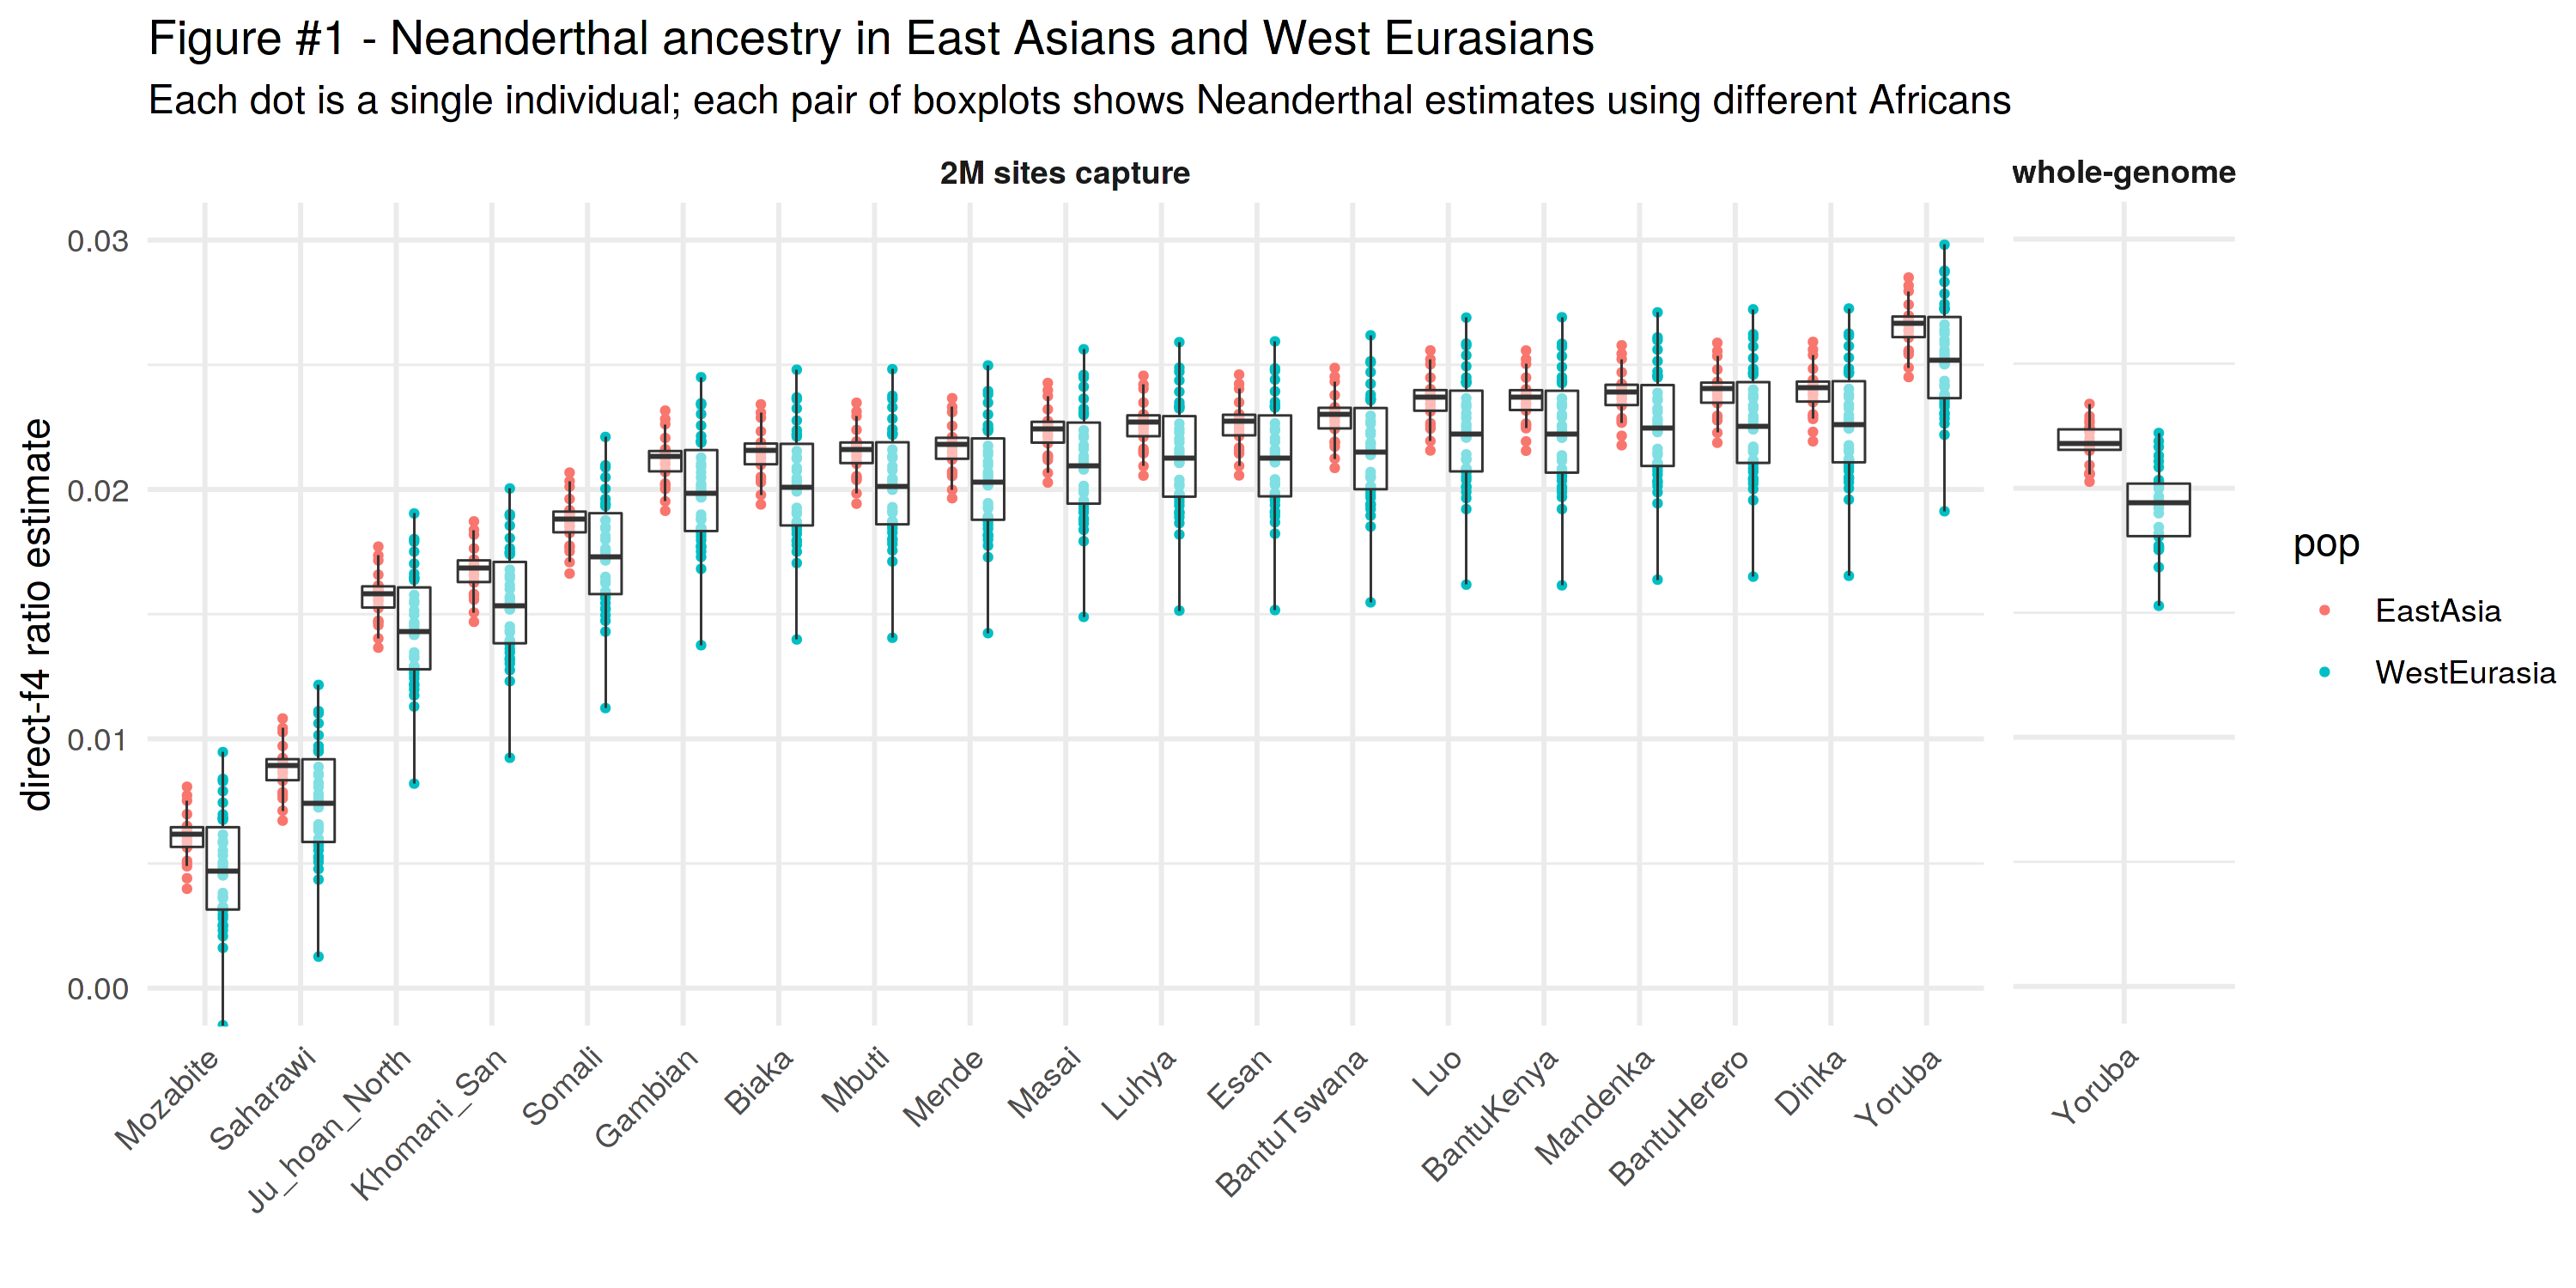

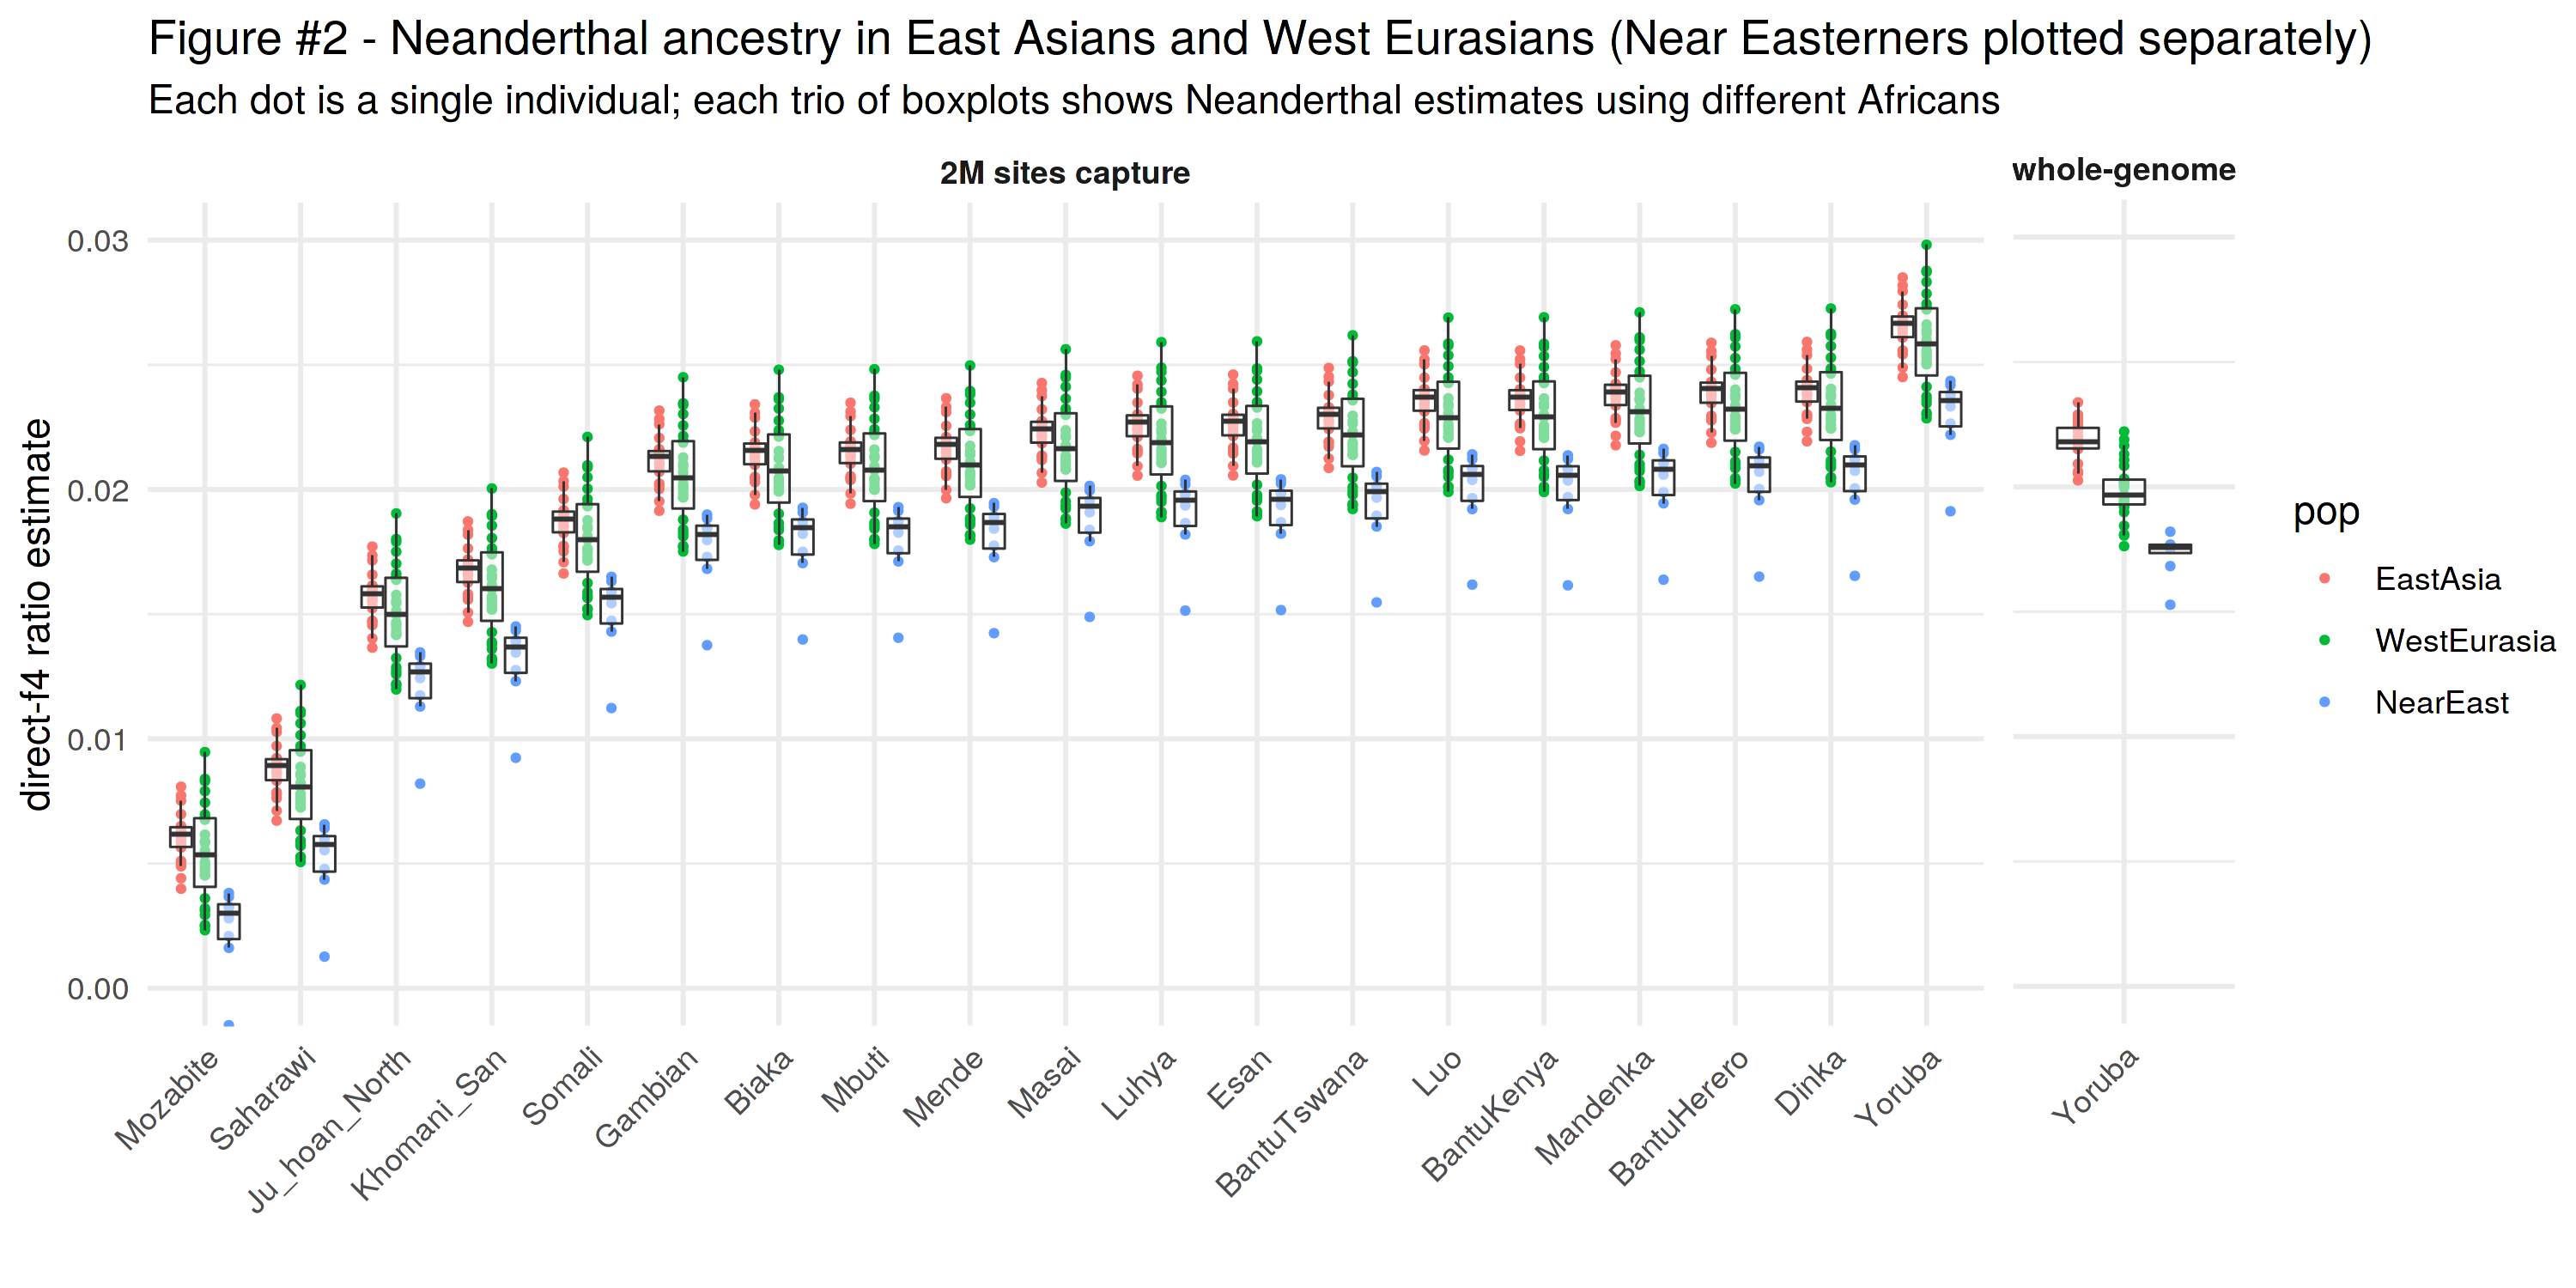

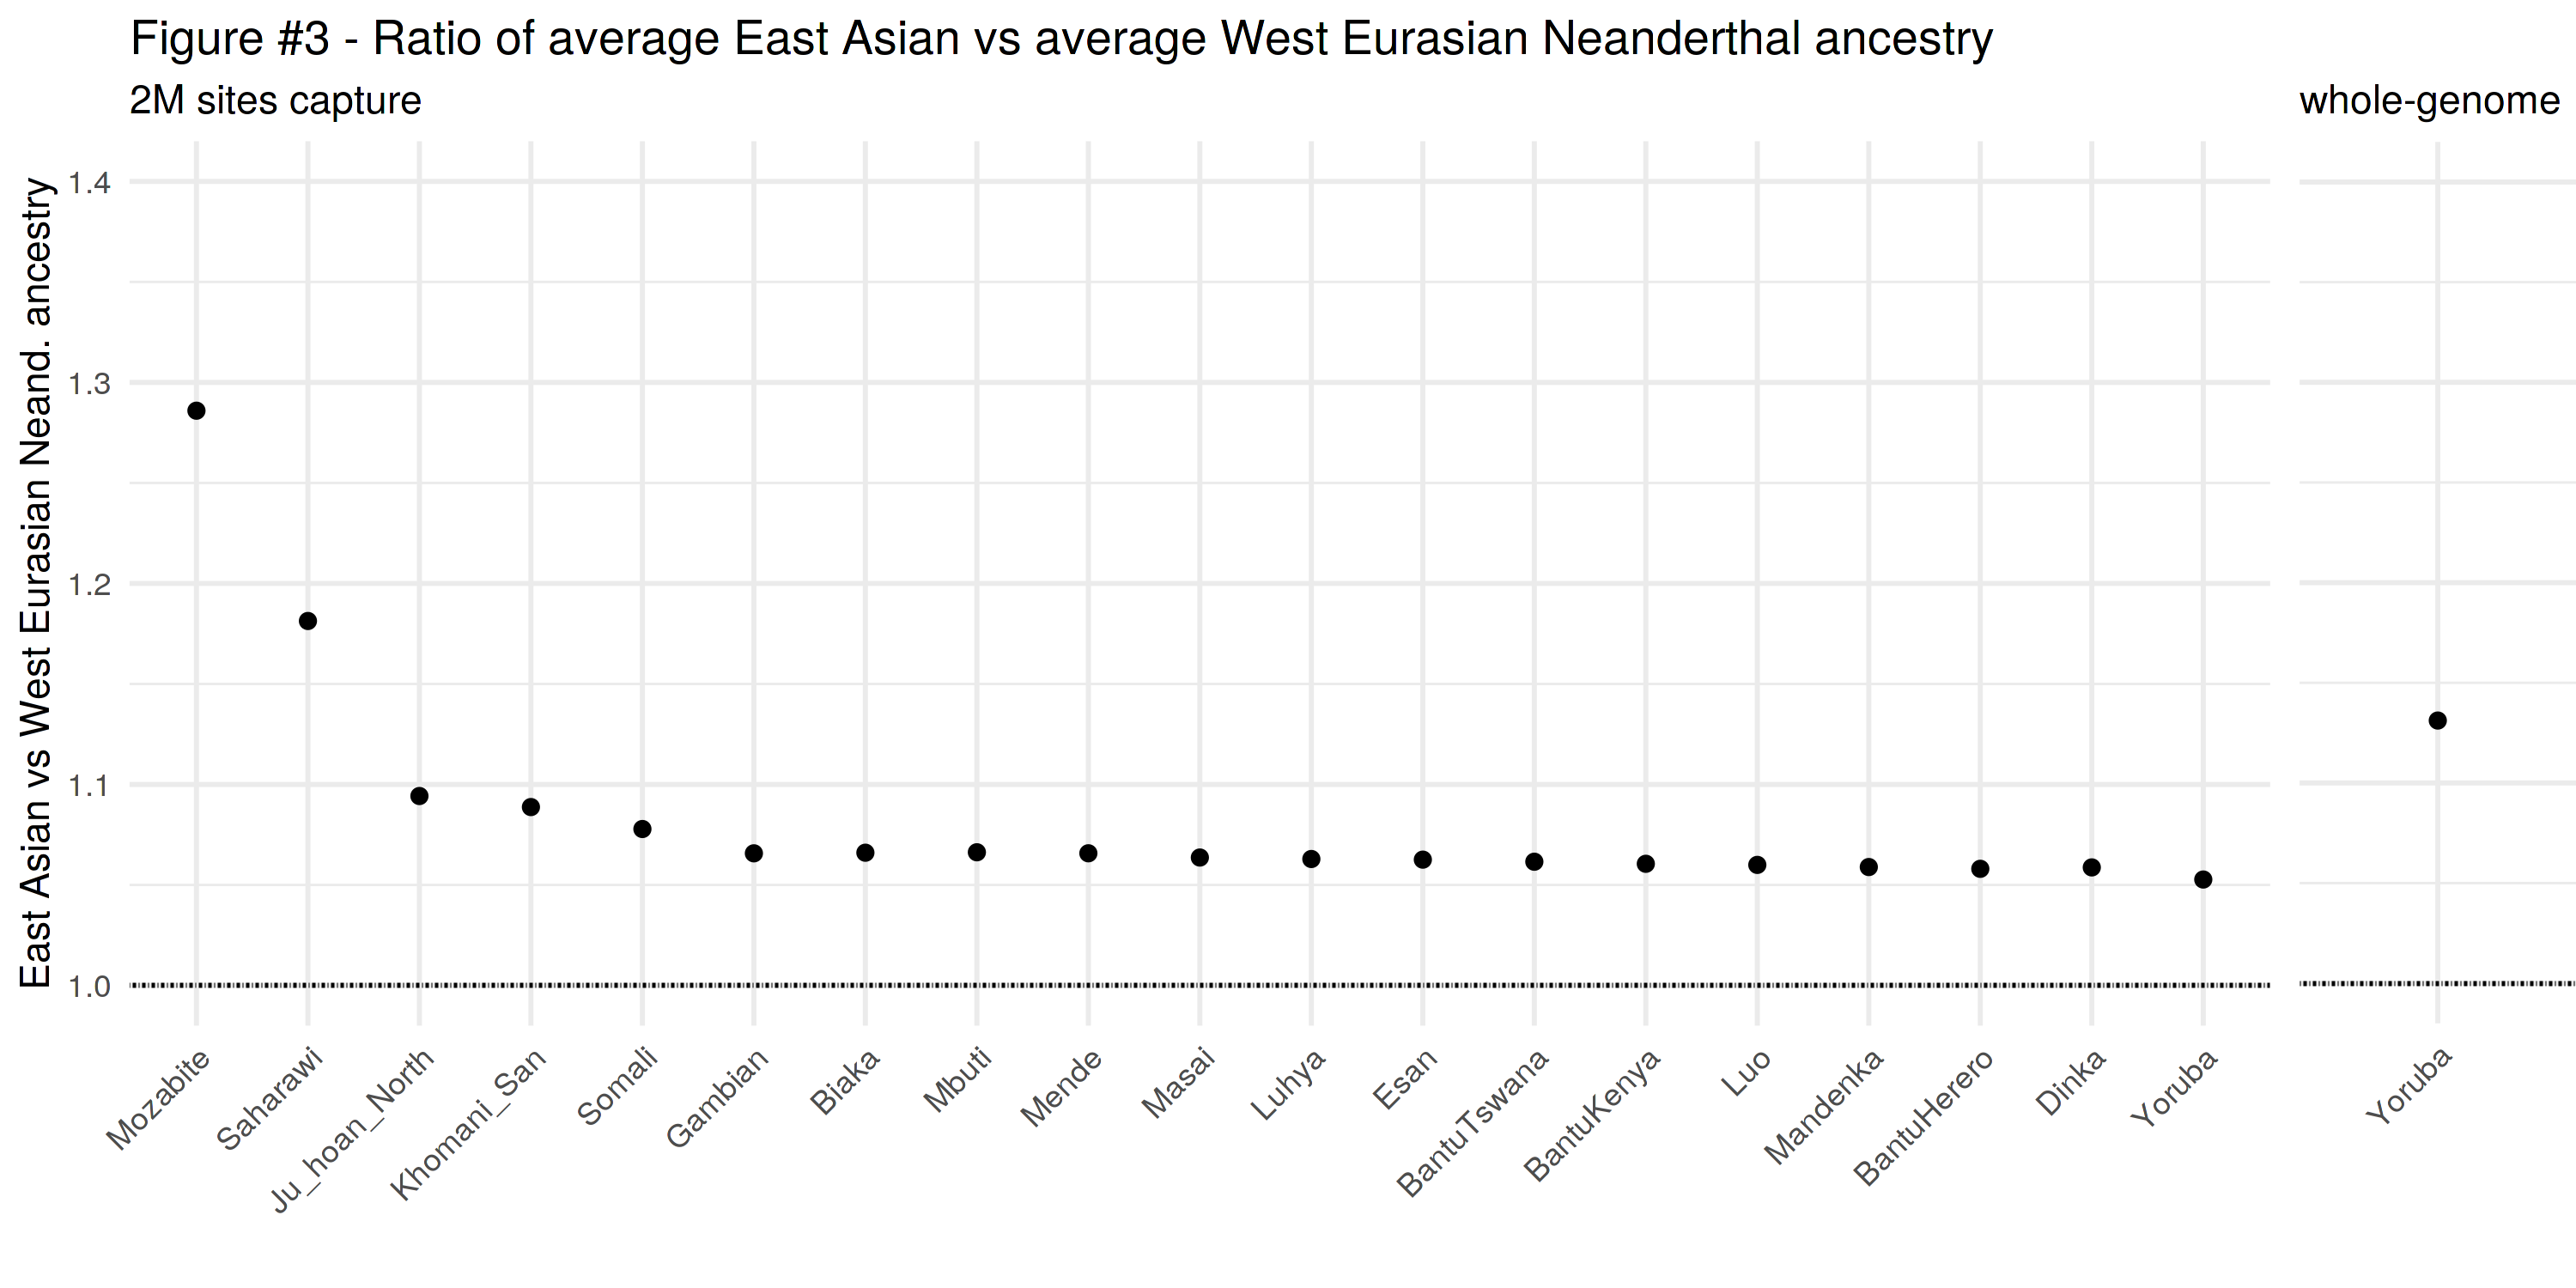

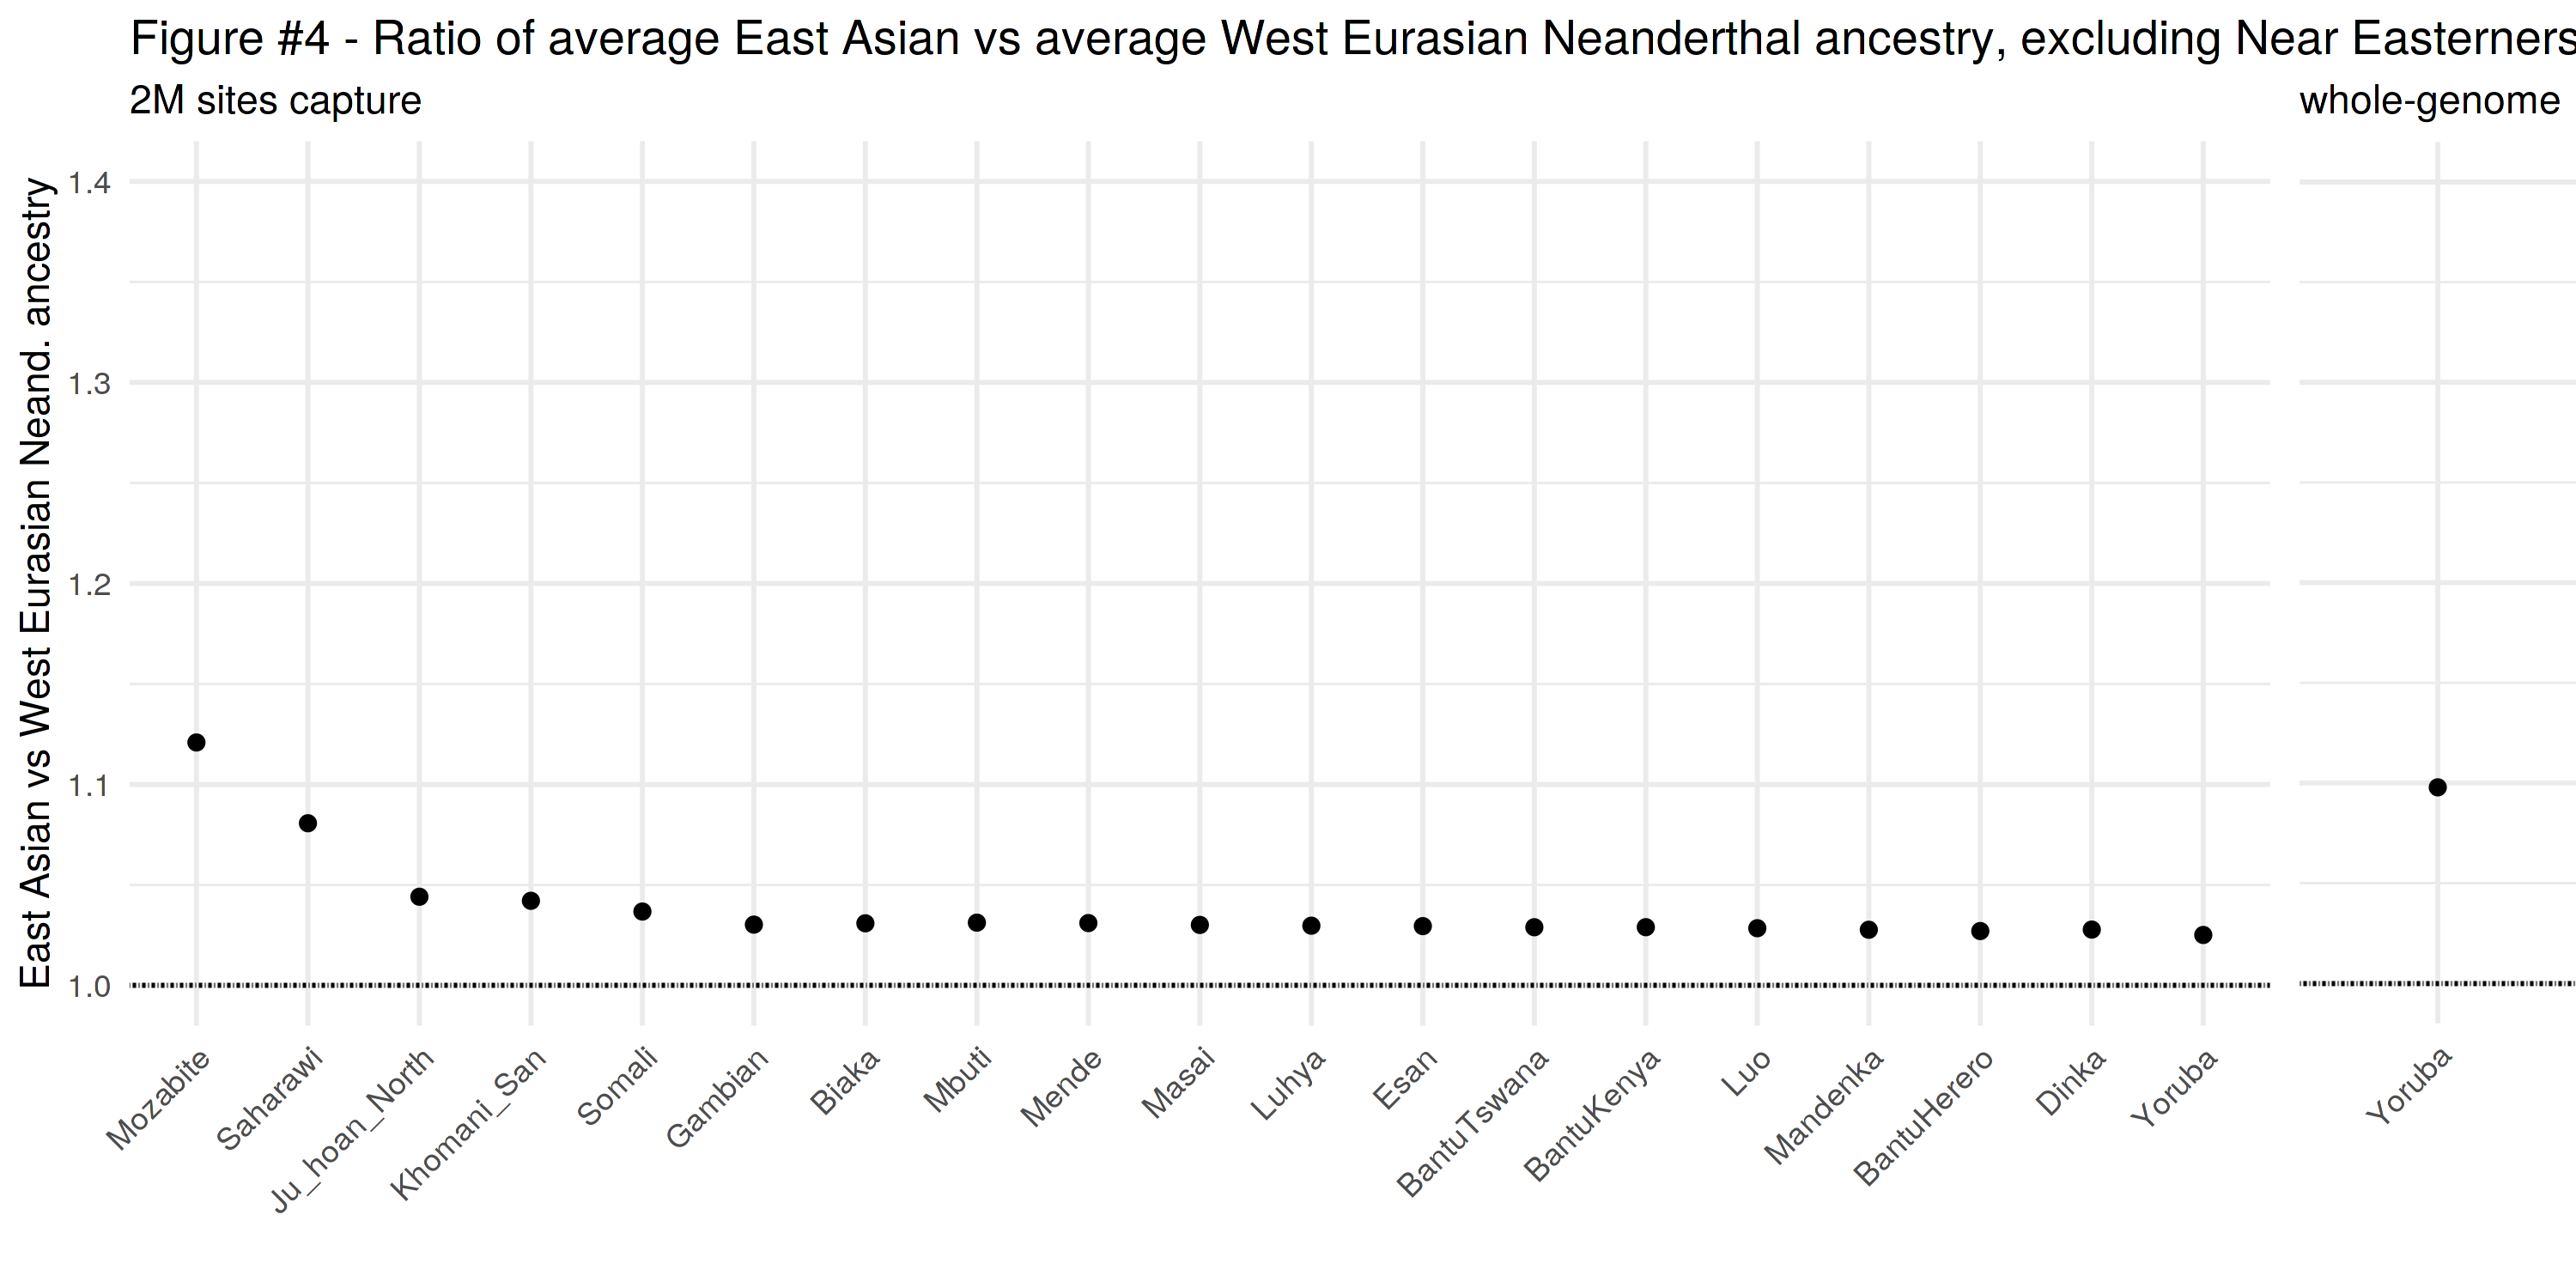

In [367]:
fig1
fig2
fig3
fig4

In [369]:
pdf("~/figures.pdf", 13, 5)
print(fig1)
print(fig2)
print(fig3)
print(fig4)
dev.off()

png 
  2